# Gila River Water Rights - Additional Analyses

## Background


## Step 0: Set-up
- Restore variables
- Load libraries

In [1]:
# Restore variables
%store -r

Unable to restore variable 'ndvi_diff', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>


In [ ]:
# Import libraries
from pathlib import Path
from glob import glob

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import rioxarray as rxr
import xarray as xr
import hvplot.pandas
import hvplot.xarray # interactive plotting using raster data
import zipfile

## Step 1: Load in NLCD land class data
### Note: This data was downloaded from https://www.mrlc.gov/viewer/

In [3]:
# Path containing .zip files
zip_dir = Path("/workspaces/data/gilariverdata/")
out_dir = Path("/workspaces/data/gilariverdata/NLCD_extracted_tifs")
out_dir.mkdir(parents=True, exist_ok=True)

# Extract and store only the .tiffs
for zip_path in zip_dir.glob("NLCD_mil1dydofjyxbs.zip"):
    with zipfile.ZipFile(zip_path, 'r') as z:
        for file in z.namelist():
            if file.lower().endswith(".tiff"):
                print(f"Extracting {file} from {zip_path.name}")
                z.extract(file, path=out_dir)

Extracting Annual_NLCD_LndCov_2001_CU_C1V1_mil1dydofjyxbs.tiff from NLCD_mil1dydofjyxbs.zip
Extracting Annual_NLCD_LndCov_2002_CU_C1V1_mil1dydofjyxbs.tiff from NLCD_mil1dydofjyxbs.zip
Extracting Annual_NLCD_LndCov_2003_CU_C1V1_mil1dydofjyxbs.tiff from NLCD_mil1dydofjyxbs.zip
Extracting Annual_NLCD_LndCov_2004_CU_C1V1_mil1dydofjyxbs.tiff from NLCD_mil1dydofjyxbs.zip
Extracting Annual_NLCD_LndCov_2005_CU_C1V1_mil1dydofjyxbs.tiff from NLCD_mil1dydofjyxbs.zip
Extracting Annual_NLCD_LndCov_2006_CU_C1V1_mil1dydofjyxbs.tiff from NLCD_mil1dydofjyxbs.zip
Extracting Annual_NLCD_LndCov_2007_CU_C1V1_mil1dydofjyxbs.tiff from NLCD_mil1dydofjyxbs.zip
Extracting Annual_NLCD_LndCov_2008_CU_C1V1_mil1dydofjyxbs.tiff from NLCD_mil1dydofjyxbs.zip
Extracting Annual_NLCD_LndCov_2009_CU_C1V1_mil1dydofjyxbs.tiff from NLCD_mil1dydofjyxbs.zip
Extracting Annual_NLCD_LndCov_2010_CU_C1V1_mil1dydofjyxbs.tiff from NLCD_mil1dydofjyxbs.zip
Extracting Annual_NLCD_LndCov_2011_CU_C1V1_mil1dydofjyxbs.tiff from NLCD_mil1dyd

In [17]:
# Open two tifs (2001 and 2022)

# 2001
nlcd_2001_path = out_dir / "Annual_NLCD_LndCov_2001_CU_C1V1_mil1dydofjyxbs.tiff"
nlcd_2001 = rxr.open_rasterio(nlcd_2001_path, mask_and_scale=True).squeeze()

# 2022
nlcd_2022_path = out_dir / "Annual_NLCD_LndCov_2022_CU_C1V1_mil1dydofjyxbs.tiff"
nlcd_2022 = rxr.open_rasterio(nlcd_2022_path, mask_and_scale=True).squeeze()

In [18]:
# Check CRS of the nlcd dataset
print("NLCD 2001 CRS:")
print(nlcd_2001.rio.crs)
print("\nGila GDF CRS:")
print(gila_gdf.crs)

NLCD 2001 CRS:
PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]

Gila GDF CRS:
EPSG:4269


In [ ]:
# Reproject gila_gdf from EPSG:4269 to match NLCD for a quick plot
gila_gdf_reproj = gila_gdf.to_crs(nlcd_2001.rio.crs)

# Check crs
print(f"NLCD CRS: {nlcd_2001.rio.crs}")
print(f"Gila GDF CRS (reprojected): {gila_gdf_reproj.crs}")

NLCD CRS: PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Gila GDF CRS (reprojected): PROJCS["AEA        WGS84",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAM

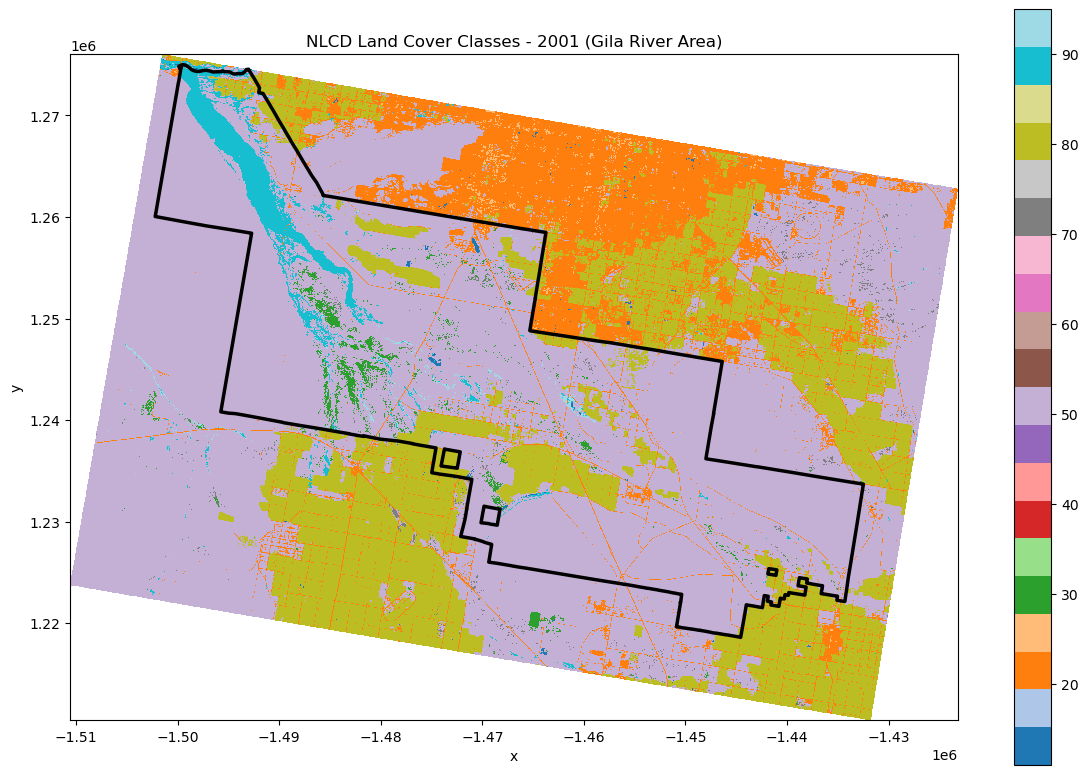

In [19]:
# Plot with boundary
fig, ax = plt.subplots(figsize=(12, 8))
nlcd_2001.plot(ax=ax, cmap='tab20', add_colorbar=True)
gila_gdf_reproj.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=2.5)
ax.set_title('NLCD Land Cover Classes - 2001 (Gila River Area)')
plt.tight_layout()
plt.show()

## Step 2: Create an Ag / non-Ag mask

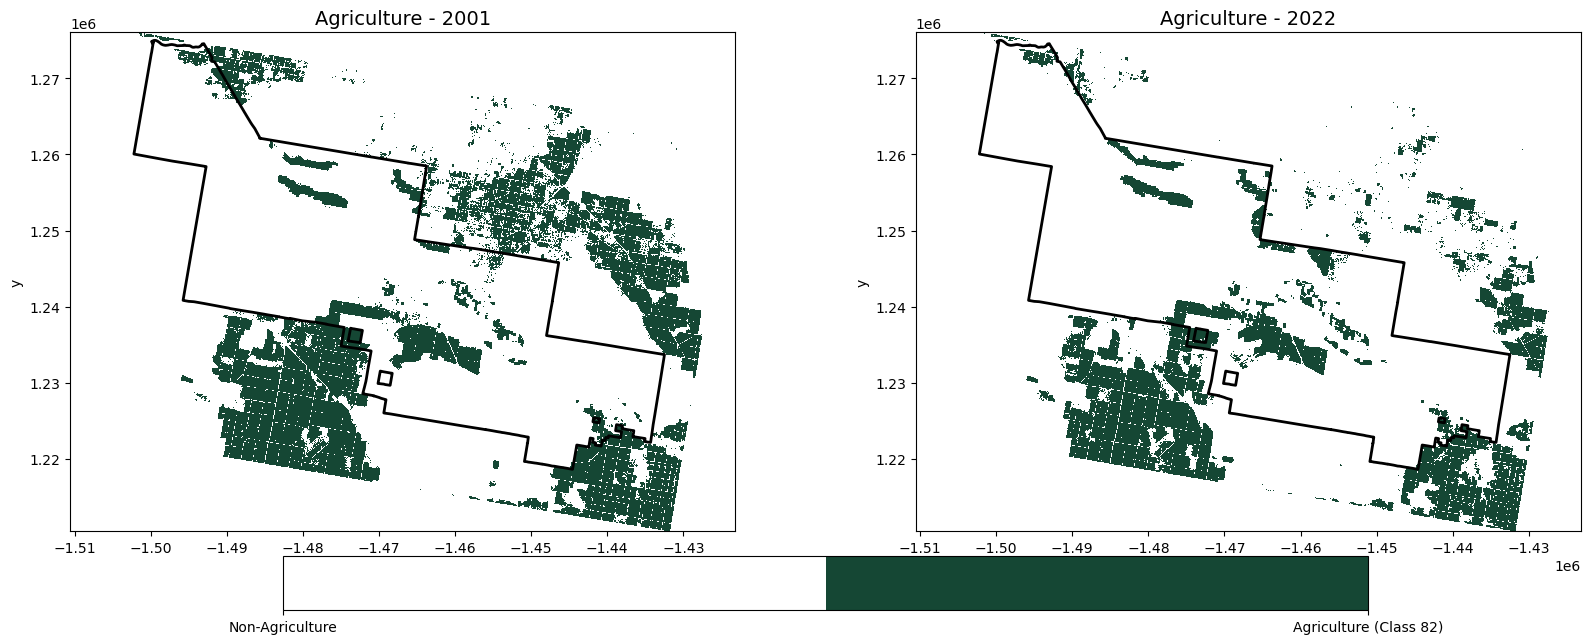

In [ ]:
# Create binary agriculture layer (1 = ag, 0 = non-ag)
# 2001
ag_2001 = xr.where(nlcd_2001 == 82, 1, 0)
ag_2001.name = 'agriculture'
# 2022
ag_2022 = xr.where(nlcd_2022 == 82, 1, 0)
ag_2022.name = 'agriculture'


# Create custom colormap: white for non-ag, dark green for ag
colors = ['white', 'darkgreen']
cmap = ListedColormap(colors)

# Plot
# Create binary agriculture layers for 2001 and 2022
ag_2001 = xr.where(nlcd_2001 == 82, 1, 0)
ag_2001.name = 'agriculture'

ag_2022 = xr.where(nlcd_2022 == 82, 1, 0)
ag_2022.name = 'agriculture'

# Create custom colormap
colors = ['white', '#154734']
cmap = ListedColormap(colors)

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 2001
im1 = ag_2001.plot(ax=axes[0], cmap=cmap, vmin=0, vmax=1, add_colorbar=False)
gila_gdf_reproj.plot(ax=axes[0], edgecolor='black', facecolor='none', linewidth=2)
axes[0].set_title('Agriculture - 2001', fontsize=14)

# Plot 2022
im2 = ag_2022.plot(ax=axes[1], cmap=cmap, vmin=0, vmax=1, add_colorbar=False)
gila_gdf_reproj.plot(ax=axes[1], edgecolor='black', facecolor='none', linewidth=2)
axes[1].set_title('Agriculture - 2022', fontsize=14)

# Add shared colorbar
cbar = fig.colorbar(im1,
                    ax=axes,
                    shrink=0.7, 
                    orientation='horizontal', 
                    pad=0.04, 
                    ticks=[0, 1])
cbar.ax.set_xticklabels(['Non-Agriculture', 'Agriculture (Class 82)'])

plt.show()

In [35]:
# Reproject agriculture mask to match NDVI
ag_2001_reproj = ag_2001.rio.reproject_match(ndvi_2001_2011)
ag_2022_reproj = ag_2022.rio.reproject_match(ndvi_2012_2022)

In [34]:
# How many less ag cells do we have 2022 compared to 2001?

# Count cells in NDVI reprojected masks
ag_cells_2001 = (ag_2001_reproj == 1).sum().values
ag_cells_2022 = (ag_2022_reproj == 1).sum().values

print(f"Agriculture cells in 2001: {ag_cells_2001:,}")
print(f"Agriculture cells in 2022: {ag_cells_2022:,}")
print(f"Change: {ag_cells_2022 - ag_cells_2001:+,} cells")

# Calculate percentage change
percent_change = ((ag_cells_2022 - ag_cells_2001) / ag_cells_2001) * 100
print(f"Percent change: {percent_change:+.2f}%")

Agriculture cells in 2001: 15,145
Agriculture cells in 2022: 8,992
Change: -6,153 cells
Percent change: -40.63%


In [ ]:
# Create agriculture change categories
# 0 = never ag
# 1 = only 2001 ag (lost agriculture)
# 2 = only 2022 ag (gained agriculture)  
# 3 = stable ag (both years)

ag_categories = xr.where(
    (ag_2001_reproj == 1) & (ag_2022_reproj == 1), 3,  # Stable ag
    xr.where(
        (ag_2001_reproj == 1) & (ag_2022_reproj == 0), 1,  # Lost ag (only 2001)
        xr.where(
            (ag_2001_reproj == 0) & (ag_2022_reproj == 1), 2,  # Gained ag (only 2022)
            0  # Never ag
        )
    )
)
ag_categories.name = 'agriculture_change'

# Pixels in each category
print(f"0 (Never Ag): {(ag_categories == 0).sum().values:,} pixels")
print(f"1 (Only 2001 Ag - Lost): {(ag_categories == 1).sum().values:,} pixels")
print(f"2 (Only 2022 Ag - Gained): {(ag_categories == 2).sum().values:,} pixels")
print(f"3 (Stable Ag): {(ag_categories == 3).sum().values:,} pixels")

0 (Never Ag): 61,572 pixels
1 (Only 2001 Ag - Lost): 6,982 pixels
2 (Only 2022 Ag - Gained): 829 pixels
3 (Stable Ag): 8,163 pixels


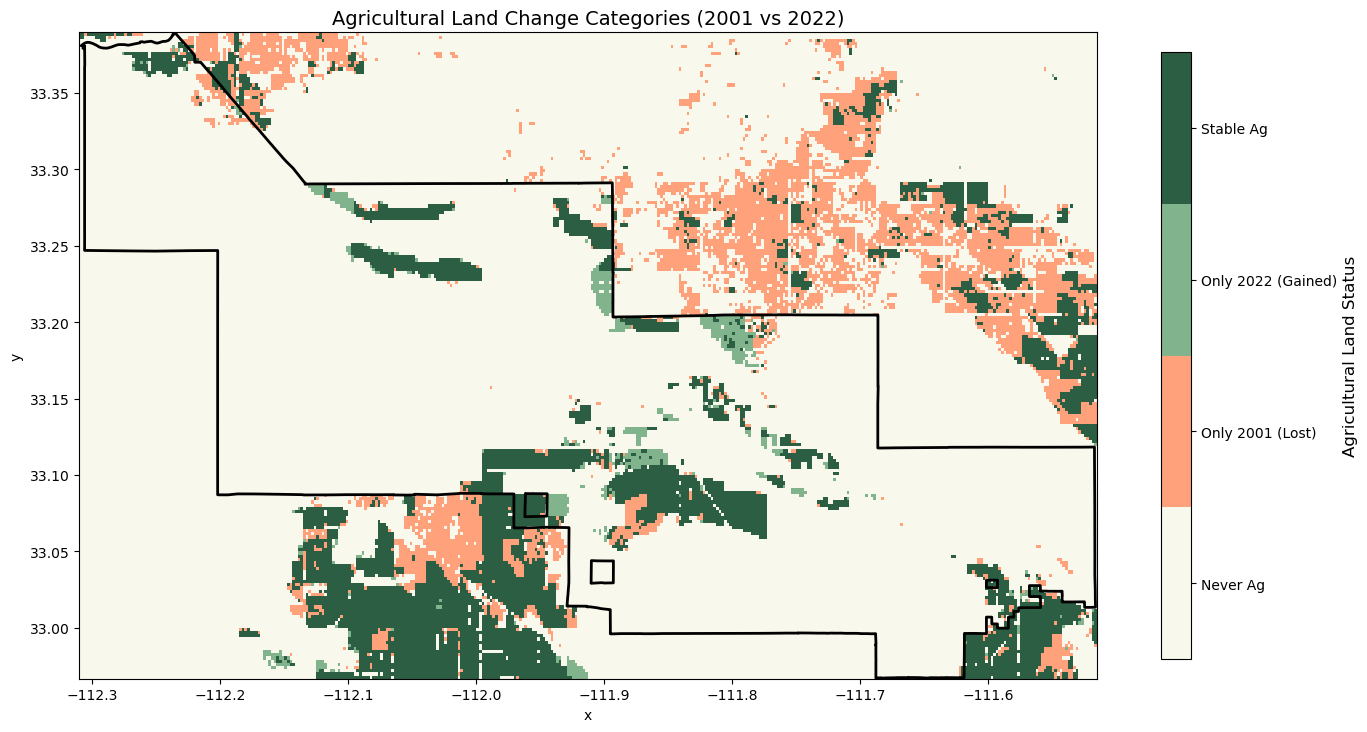

In [ ]:
# Plot ag change categories

# colormap for ag categories 
ag_colors = ['#f9f8ed', '#ffa27c', '#81b38d', '#2c5e43']
ag_labels = ['Never Ag', 'Only 2001 (Lost)', 'Only 2022 (Gained)', 'Stable Ag']
ag_cmap = ListedColormap(ag_colors)

# Plot
fig, ax = plt.subplots(figsize=(14, 8))
im = ag_categories.plot(ax=ax, 
                        cmap=ag_cmap, 
                        vmin=0, 
                        vmax=3, 
                        add_colorbar=False)
gila_gdf.plot(ax=ax, 
              edgecolor='black', 
              facecolor='none', 
              linewidth=2)

# Custom colorbar with proper labels
cbar = plt.colorbar(im, 
                    ax=ax, 
                    ticks=[0.375, 1.125, 1.875, 2.625], 
                    shrink=0.8)
cbar.ax.set_yticklabels(ag_labels)
cbar.set_label('Agricultural Land Status', fontsize=12)

ax.set_title('Agricultural Land Change Categories (2001 vs 2022)', fontsize=14)
plt.tight_layout()
plt.show()

Some quick thoughts about this map
- Lots of ag loss, especially adjacent to SE Phoenix / Chandler
- Ag gain and stable within the Gila River Tribal Area

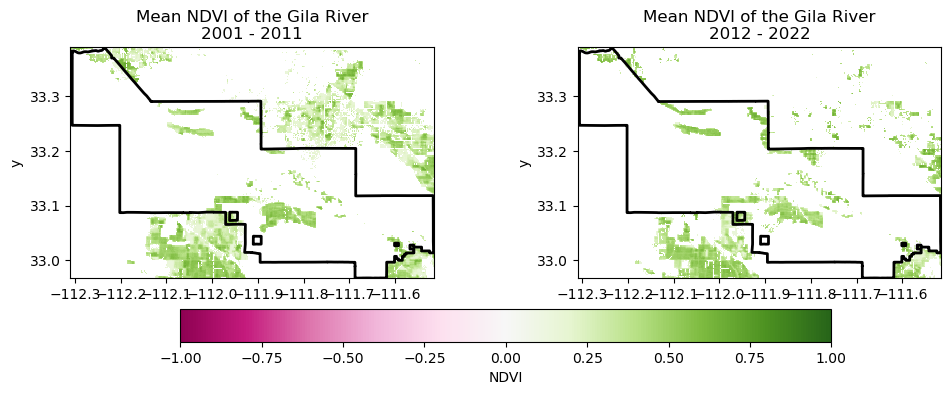

In [ ]:
# Mask NDVI to show only agriculture areas
ndvi_2001_2011_ag = ndvi_2001_2011.where(ag_2001_reproj == 1)
ndvi_2012_2022_ag = ndvi_2012_2022.where(ag_2022_reproj == 1)

# Create side by side plot
fig, axes = plt.subplots(1, 2, figsize =(12,4))


# Plot each in their own axes

# First decade mean NDVI 
im1 = ndvi_2001_2011_ag.plot(ax=axes[0], 
                    cmap=plt.cm.PiYG, 
                    vmin=-1,vmax=1,
                    add_colorbar=False
                    )
# Plot boundary
gila_gdf.plot(ax=axes[0], edgecolor='black', 
              facecolor='none', linewidth=2)
axes[0].set_title("Mean NDVI of the Gila River\n2001 - 2011")


# Recent NDVI
ndvi_2012_2022_ag.plot(ax=axes[1], 
                    cmap=plt.cm.PiYG, 
                    vmin=-1,vmax=1,
                    add_colorbar=False)
# Plot boundary
gila_gdf.plot(ax=axes[1], edgecolor='black', 
              facecolor='none', linewidth=2)
axes[1].set_title("Mean NDVI of the Gila River\n2012 - 2022")

# Add in scale for first two plots
cbar1 = fig.colorbar(im1, 
                    ax=axes[:2], 
                    shrink=0.7, 
                    orientation="horizontal", 
                    pad=0.1)
cbar1.set_label("NDVI")